In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
plots.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
patients = Table.read_table('https://raw.githubusercontent.com/data-8/textbook/main/assets/data/breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


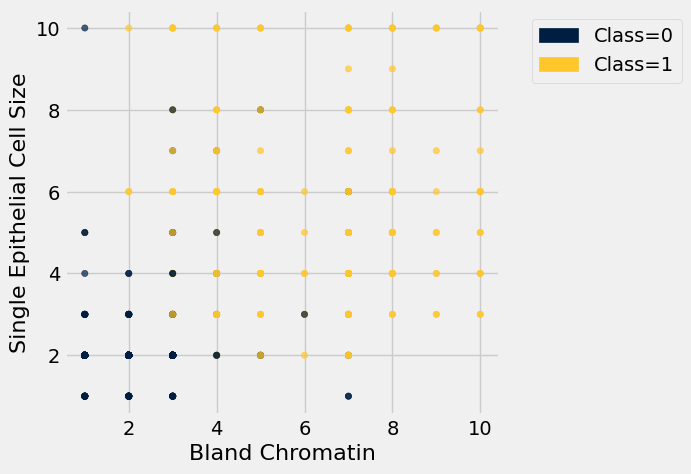

In [3]:
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Class')

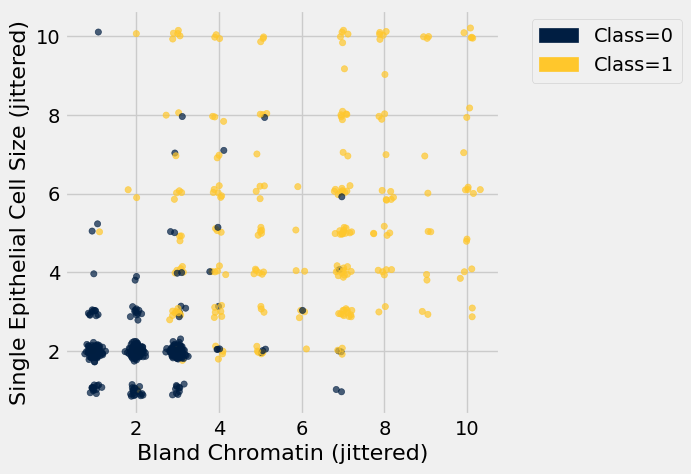

In [4]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))


jittered = Table().with_columns([
    'Bland Chromatin (jittered)',
    randomize_column(patients.column('Bland Chromatin')),
    'Single Epithelial Cell Size (jittered)',
    randomize_column(patients.column('Single Epithelial Cell Size')),
    'Class',
    patients.column('Class')
])

jittered.scatter('Bland Chromatin (jittered)', 'Single Epithelial Cell Size (jittered)', group='Class')

## Distance

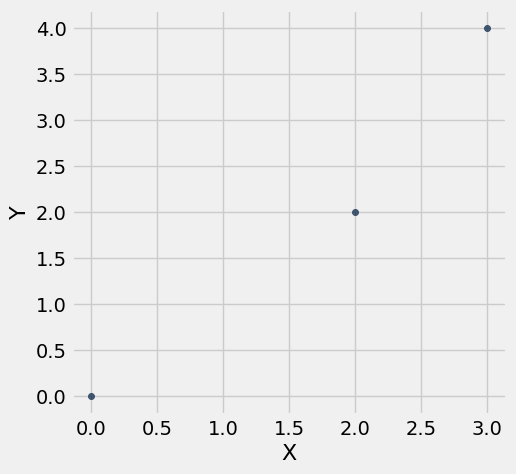

In [5]:
Table().with_columns(['X', [0,2,3], 'Y', [0,2,4]]).scatter('X', 'Y')

In [6]:
def distance(pt1, pt2):
    """Distance between two points (represented as arrays.)"""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """Distance between two rows."""
    return distance(np.array(row1), np.array(row2))

In [7]:
attributes = patients.drop('Class')
attributes.show(3)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1


In [8]:
row_distance(attributes.row(0), attributes.row(1))

11.874342087037917

In [9]:
row_distance(attributes.row(0), attributes.row(2))

2.2360679774997898

In [10]:
row_distance(attributes.row(0), attributes.row(0))

0.0

## Classification Procedure

In [31]:
def distances(training, example):
    """Compute a table with the training set and distances to the example for each row in the training set."""
    dists = []
    attributes = training.drop('Class')
    for row in attributes.rows:
        dist = row_distance(row, example)
        dists.append(dist)
    return training.with_column('Distance', dists)

In [32]:
def closest(training, example, k):
    """Return a table of the k closets neighbors to example."""
    return distances(training, example).sort('Distance').take(np.arange(k))

In [33]:
patients.take(12)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,3,3,3,2,3,4,4,1,1


In [34]:
example = patients.drop('Class').row(12)
example

Row(Clump Thickness=5, Uniformity of Cell Size=3, Uniformity of Cell Shape=3, Marginal Adhesion=3, Single Epithelial Cell Size=2, Bare Nuclei=3, Bland Chromatin=4, Normal Nucleoli=4, Mitoses=1)

In [35]:
closest(patients, example, 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
5,3,3,3,2,3,4,4,1,1,0
5,3,3,4,2,4,3,4,1,1,1.73205
5,1,3,3,2,2,2,3,1,0,3.16228
5,2,2,2,2,2,3,2,2,0,3.16228
5,3,3,1,3,3,3,3,3,1,3.31662


In [36]:
closest(patients.exclude(12), example, 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
5,3,3,4,2,4,3,4,1,1,1.73205
5,1,3,3,2,2,2,3,1,0,3.16228
5,2,2,2,2,2,3,2,2,0,3.16228
5,3,3,1,3,3,3,3,3,1,3.31662
4,3,3,1,2,1,3,3,1,0,3.31662


In [52]:
def majority_class(neighbors):
    """Return the class that's most common among all these neighbors."""
    return neighbors.group('Class').sort('count', descending=True).column('Class').item(0)

In [53]:
def classify(training, example, k):
    """Return the majority class among the k nearest neighbors."""
    nearest_neighbors = closest(training, example, k)
    return majority_class(nearest_neighbors)

In [54]:
classify(patients.exclude(12), example, 5)

0

## Evaluation

In [56]:
patients.num_rows

683

In [57]:
shuffled = patients.sample(with_replacement=False) # Randomly permute the rows
trainset = shuffled.take(range(0, 342))
testset = shuffled.take(range(342, 683))

In [58]:
def evaluate_accurancy(training, test, k):
    test_attributes = test.drop('Class')
    numcorrect = 0
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        test_patient = test_attributes.row(i)
        c = classify(training, test_patient, k)
        # Was the classifier's prediction correct?
        if c == test.column('Class').item(i):
            numcorrect = numcorrect + 1
    return numcorrect / test.num_rows

In [59]:
evaluate_accurancy(trainset, testset, 5)

0.967741935483871

In [60]:
evaluate_accurancy(trainset, testset, 1)

0.9706744868035191

In [61]:
evaluate_accurancy(trainset, trainset, 5)

0.9824561403508771

In [62]:
evaluate_accurancy(trainset, trainset, 1)

1.0

## Decision boundaries

In [64]:
ckd = Table.read_table('https://raw.githubusercontent.com/data-8/textbook/main/assets/data/ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1


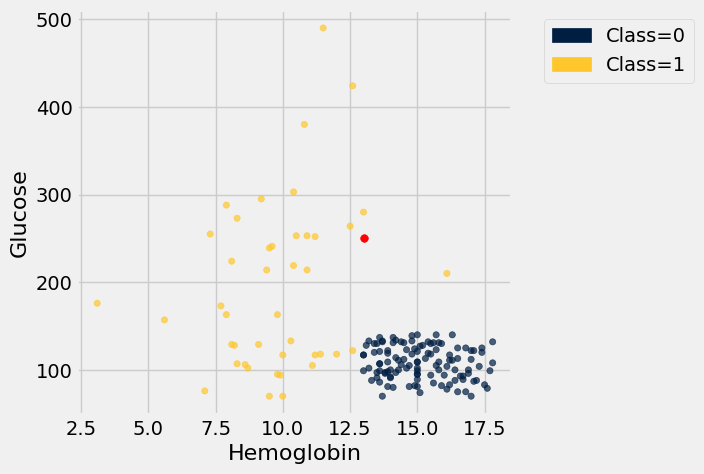

In [66]:
kidney = ckd.select('Hemoglobin', 'Glucose', 'Class')
kidney.scatter('Hemoglobin', 'Glucose', group=2)
plots.scatter(13, 250, color='red', s=30)

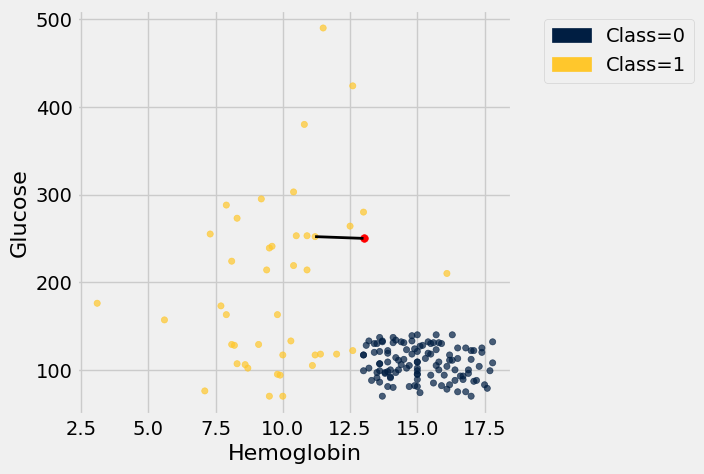

In [68]:
def show_closest(t, point):
    """Show closest trainin example to a point."""
    near = closest(t, point, 1).row(0)
    t.scatter(0, 1, group='Class')
    plots.scatter(point.item(0), point.item(1), color='red', s=30)
    plots.plot([point.item(0), near.item(0)], [point.item(1), near.item(1)], color='k', lw=2)
    
show_closest(kidney, make_array(13, 250))

In [71]:
def standard_units(any_numbers):
    """Convert any array of numbers to standard units."""
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

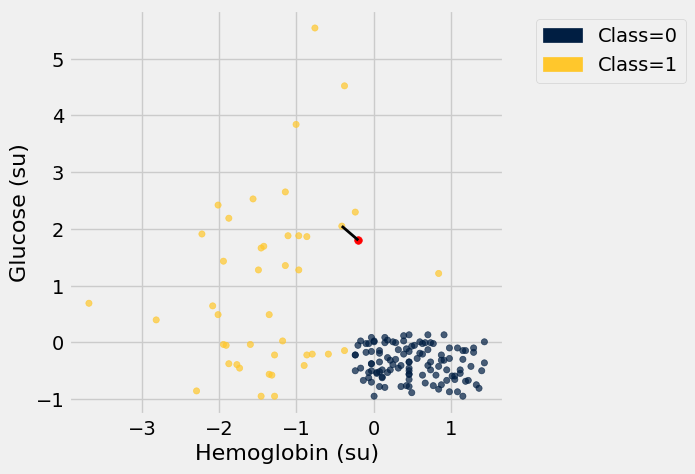

In [74]:
kidney_su = standardize(kidney.drop('Class')).with_column('Class', kidney.column('Class'))
show_closest(kidney_su, make_array(-0.2, 1.8))

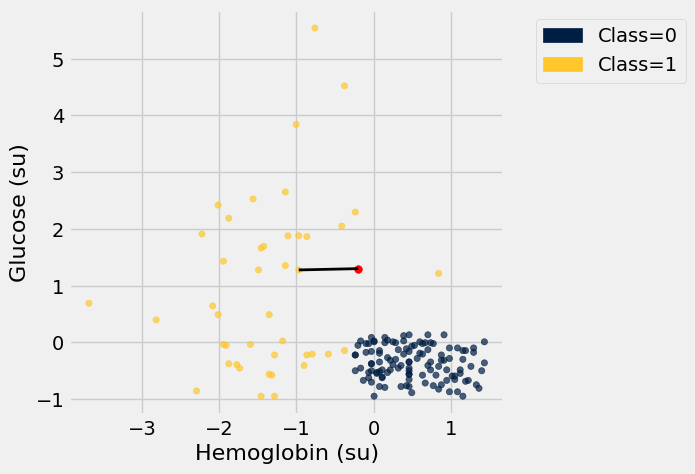

In [75]:
show_closest(kidney_su, make_array(-0.2, 1.3))

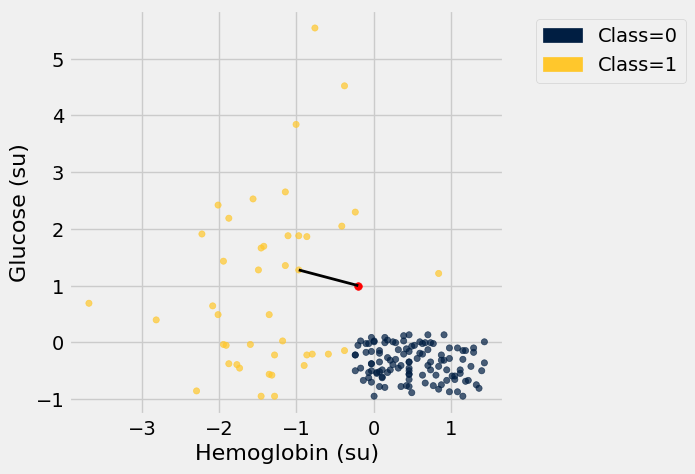

In [76]:
show_closest(kidney_su, make_array(-0.2, 1))

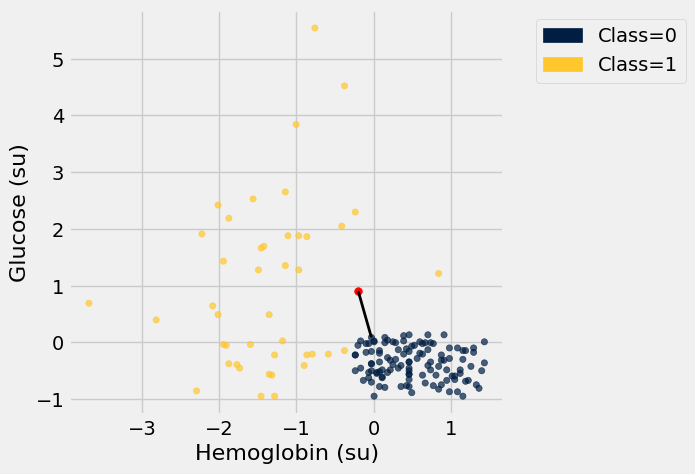

In [77]:
show_closest(kidney_su, make_array(-0.2, 0.9))

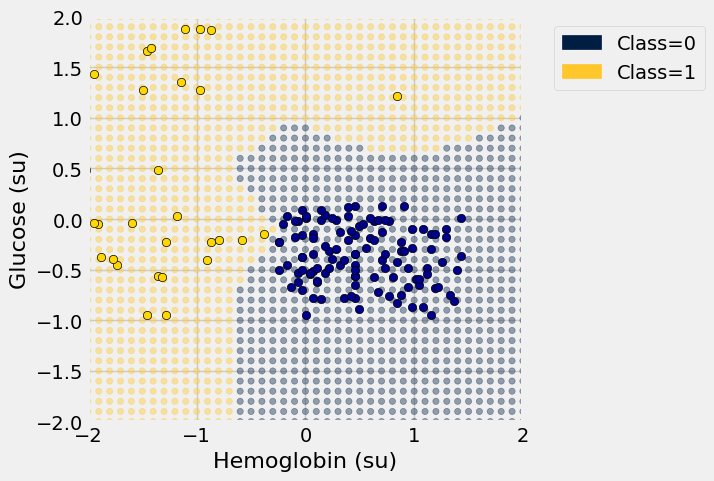

In [79]:
def decision_boundary(t, k):
    """Decision boundary of a two-column + Class table."""
    t_su = standardize(t.drop('Class')).with_column('Class', t.column('Class'))
    decisions = Table(t_su.labels)
    for x in np.arange(-2, 2.1, 0.1):
        for y in np.arange(-2, 2.1, 0.1):
            predicted = classify(t_su, make_array(x, y), k)
            decisions.append([x, y, predicted])
    decisions.scatter(0, 1, group='Class', alpha=0.4)
    plots.xlim(-2, 2)
    plots.ylim(-2, 2)
    t_su_0 = t_su.where('Class', 0)
    t_su_1 = t_su.where('Class', 1)
    plots.scatter(t_su_0.column(0), t_su_0.column(1), c='darkblue', edgecolor='k')
    plots.scatter(t_su_1.column(0), t_su_1.column(1), c='gold', edgecolor='k')
    
decision_boundary(kidney, 1)

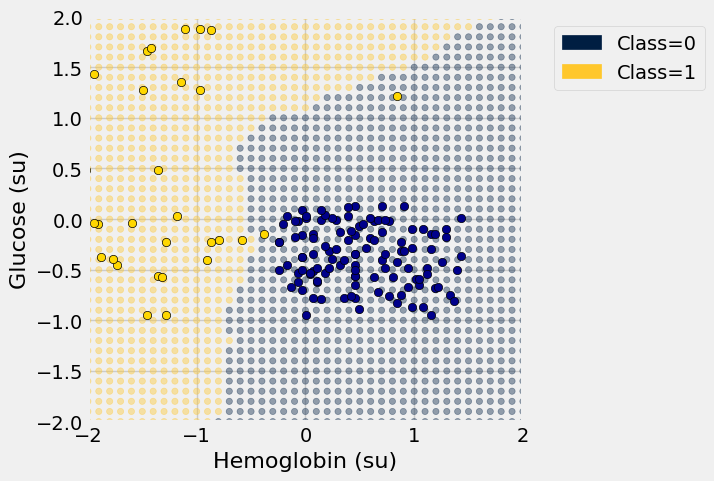

In [80]:
decision_boundary(kidney, 5)

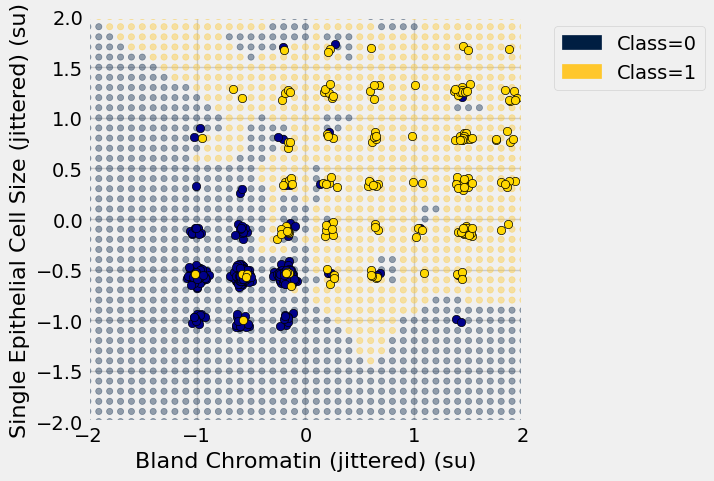

In [81]:
decision_boundary(jittered, 1)

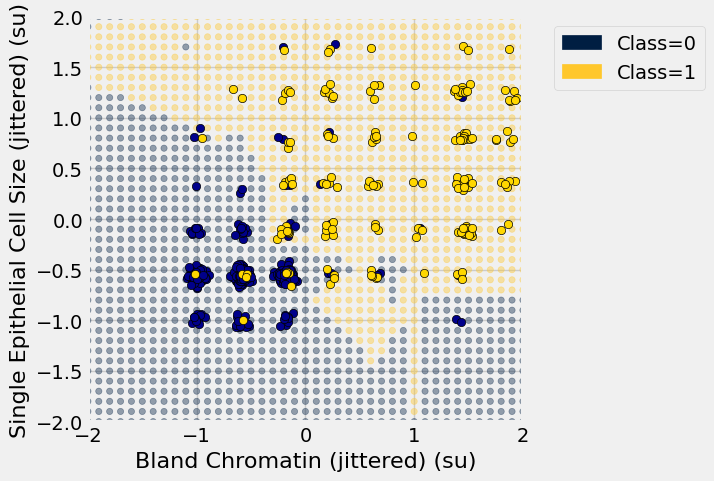

In [82]:
decision_boundary(jittered, 5)